# Detecting Credit Card Fraud

**Following the framework proposed by [in this article](https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/
)**

**[Using this dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/)**

## Load data

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

data = pd.read_csv('/content/drive/MyDrive/Projects/credit_card_fraud/creditcard.csv')

In [ ]:


data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Create a balanced dataset** for more accurate EDA. The imbalanced dataset will for example, effect the correlations of each feature with the Class

In [ ]:
# Separate data by class
class_0 = data[data['Class'] == 0]
class_1 = data[data['Class'] == 1]

# Sample class 0 data, so that it doesnt completely overwhelm the class 1 data
class_0_sample = class_0.sample(n=len(class_1))

# Combine sampled class 0 data with class 1 data
data_sampled = pd.concat([class_0_sample, class_1])

# Shuffle the dataset
balanced_data = data_sampled.sample(frac=1)

print(balanced_data.Class.value_counts())

Class
0    492
1    492
Name: count, dtype: int64


## Univariate Analysis

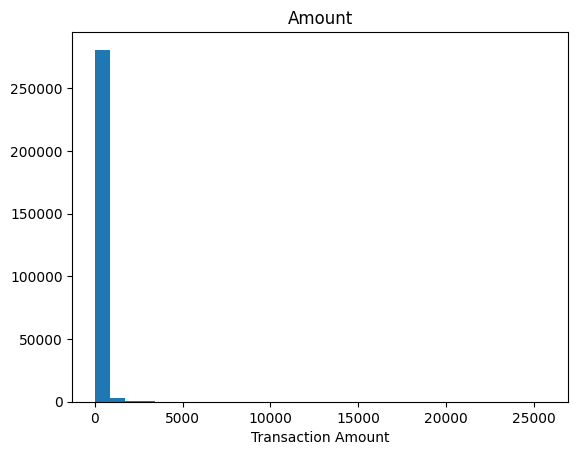

In [ ]:
# Looking at the transaction amount
data.hist(column='Amount', bins=30, grid=False)
plt.xlabel('Transaction Amount')
plt.show()

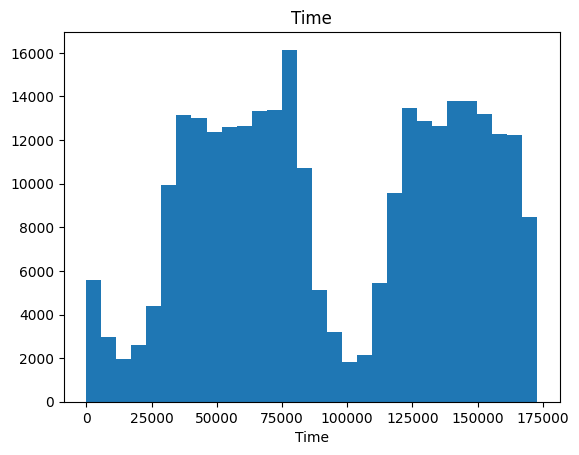

In [ ]:
# Looking at Time
data.hist(column='Time', bins=30, grid=False)
plt.xlabel('Time')
plt.show()

In [ ]:
# NA values?
data[data.isnull().any(axis=1)]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


No na values

In [ ]:
# Looking at the label (Class)
100 * data.Class.value_counts()/len(data)

Class
0    99.827251
1     0.172749
Name: count, dtype: float64

The data is ***extremely unbalanced***, with 99.83% as non-fraud, and 0.17% as fraud

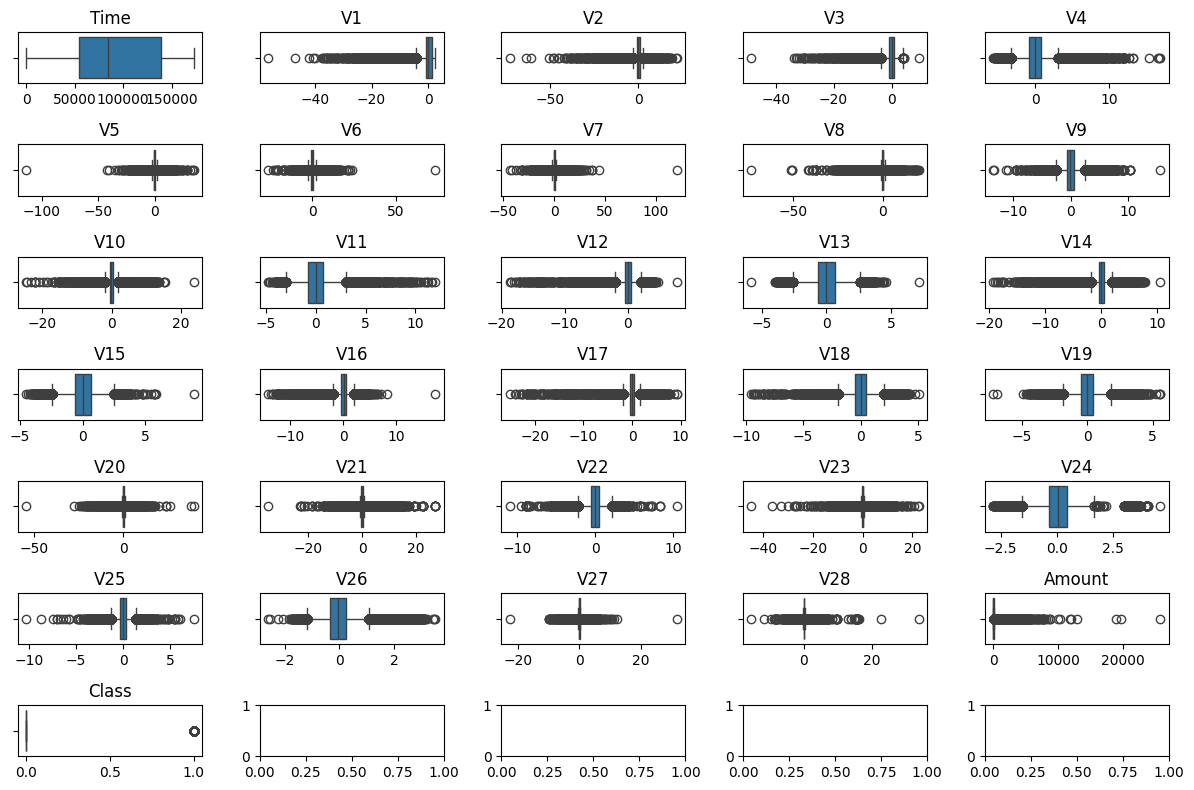

In [ ]:
num_features = data.shape[1] -1

fig, axes = plt.subplots(num_features//5 + 1, 5, figsize=(12,8))

for i, col_name in enumerate(data.columns):
    row, col = divmod(i, 5)
    sns.boxplot(x=data[col_name], ax=axes[row, col])
    axes[row, col].set_title(col_name)
    axes[row, col].set_xlabel("")


plt.tight_layout()
plt.show()

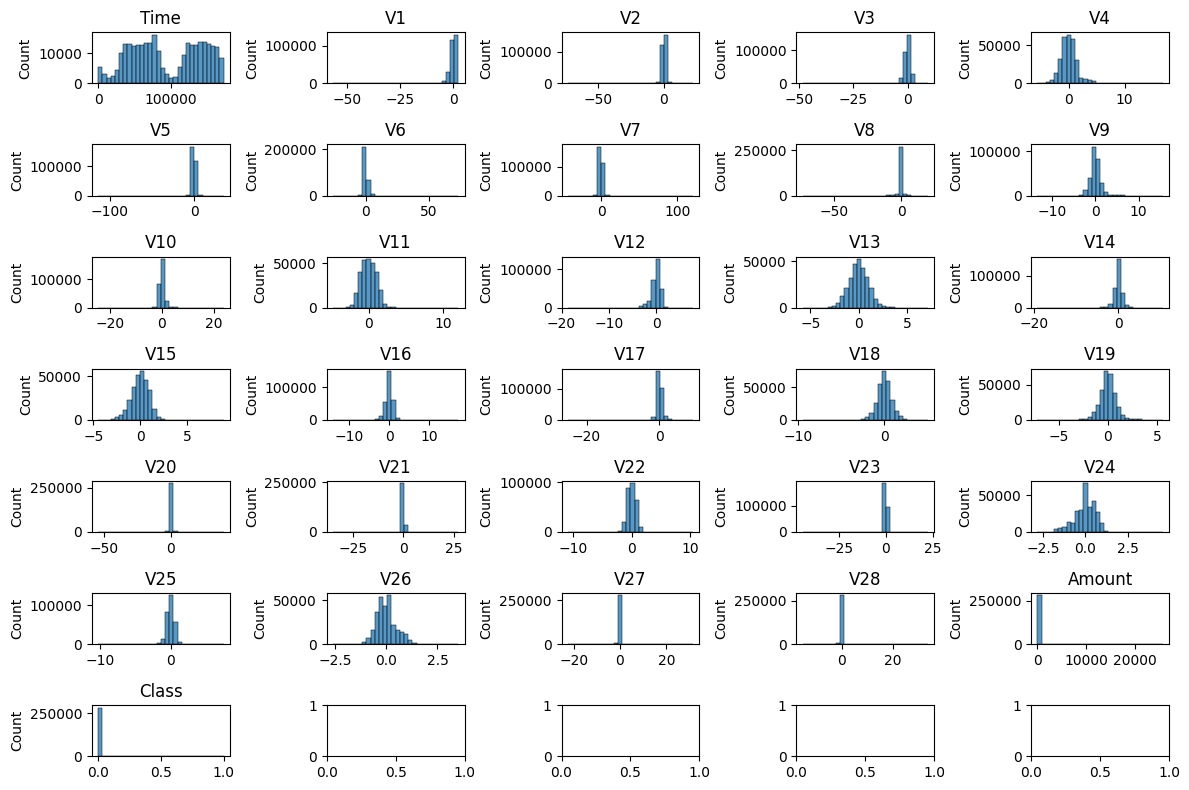

In [ ]:
num_features = data.shape[1] -1

fig, axes = plt.subplots(num_features//5 + 1, 5, figsize=(12,8))

for i, col_name in enumerate(data.columns):
    row, col = divmod(i, 5)
    sns.histplot(x=data[col_name], ax=axes[row, col], bins=30)
    axes[row, col].set_title(col_name)
    axes[row, col].set_xlabel("")


plt.tight_layout()
plt.show()

Most features look to be normally distributed, many with outliers

## Bivariate Analysis


<ipython-input-12-e8fe5aa0d698>:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  data.hist(column='Amount', by='Class', bins=30, grid=False, sharex=True, ax=axis)


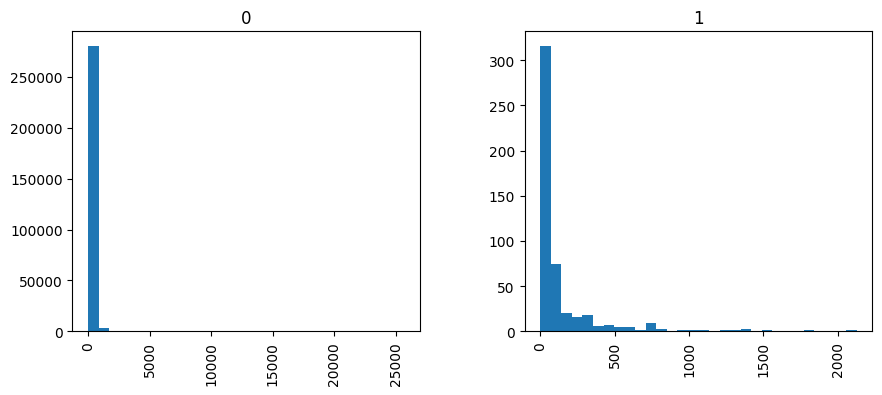

In [ ]:
# Check if the amount is related at all to if its fraud
fig, axis = plt.subplots(1, 2, figsize=(10, 4))
data.hist(column='Amount', by='Class', bins=30, grid=False, sharex=True, ax=axis)

plt.show()

It's not immediatly obvious if there is a difference in distribution of transaction amount between fraud and non-fraud. Lets conduct statistical test to see

In [ ]:
from scipy import stats

# Kolmogorov-Smirnov (KS) test
amount_0 = data.Amount[data.Class==0]
amount_1 = data.Amount[data.Class==1]

ks_result = stats.ks_2samp(amount_0, amount_1)
print(ks_result)

KstestResult(statistic=0.27119151307757383, pvalue=2.1703053464297685e-32, statistic_location=1.18, statistic_sign=-1)


Because the resulting pvalue is < 0.05, we can reject the null hypothesis that the distributions are same. **The transaction amount distributions are significantly different between class 0 and class 1**.

Lets do a QQplot to visualize

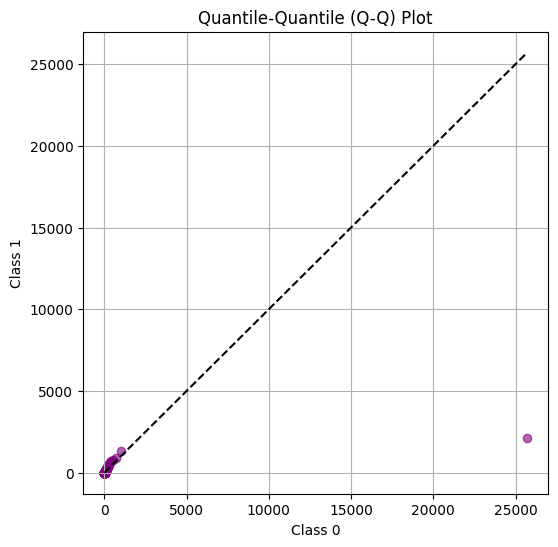

In [ ]:
# Get quantiles for each class
q_0 = np.percentile(amount_0, np.linspace(0,100,100))
q_1 = np.percentile(amount_1, np.linspace(0,100,100))

# Create q-q plot
plt.figure(figsize=(6, 6))
plt.scatter(q_0, q_1, color='purple', alpha=0.6)
plt.plot([q_0.min(), q_0.max()], [q_0.min(), q_0.max()], 'k--')
plt.xlabel('Class 0')
plt.ylabel('Class 1')
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.grid(True)
plt.show()

In [ ]:
print(amount_1.sort_values(ascending=False))
print(len(amount_0[amount_0 > 2500]))
print(len(amount_0))

176049    2125.87
6971      1809.68
249167    1504.93
89190     1402.16
81609     1389.56
           ...   
143334       0.00
69980        0.00
248296       0.00
93788        0.00
541          0.00
Name: Amount, Length: 492, dtype: float64
440
284315


Looks like theres a few outliers that make it so that the fraud transactions are a different distribution than the non-fraud transactions. However, these are all very high outliers in class 0. Lets remove them and re-evaluate

In [ ]:
# Remove outliers from amount_1
zscores = np.abs(stats.zscore(amount_0))

threshold = 10
amount_0_rm_outliers = amount_0[zscores < threshold]
print(amount_0_rm_outliers.sort_values(ascending=False))
print(f'Number of records removed: {len(amount_0)-len(amount_0_rm_outliers)}')

195845    2584.12
212489    2583.54
195694    2572.33
95973     2571.80
107309    2571.28
           ...   
280631       0.00
32518        0.00
160410       0.00
280641       0.00
202424       0.00
Name: Amount, Length: 283908, dtype: float64
Number of records removed: 407


KstestResult(statistic=0.27103541270841086, pvalue=2.365390660187674e-32, statistic_location=1.18, statistic_sign=-1)



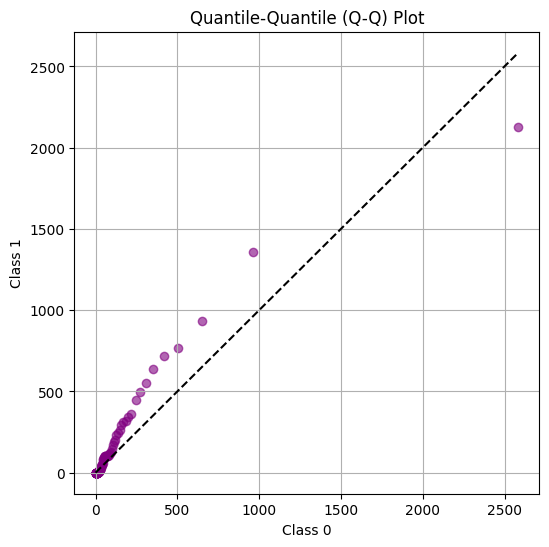

In [ ]:
# Kolmogorov-Smirnov (KS) test
ks_result = stats.ks_2samp(amount_0_rm_outliers, amount_1)
print(ks_result)
print()

# Get quantiles for each class
q_0 = np.percentile(amount_0_rm_outliers, np.linspace(0,100,100))
q_1 = np.percentile(amount_1, np.linspace(0,100,100))

# Create q-q plot
plt.figure(figsize=(6, 6))
plt.scatter(q_0, q_1, color='purple', alpha=0.6)
plt.plot([q_0.min(), q_0.max()], [q_0.min(), q_0.max()], 'k--')
plt.xlabel('Class 0')
plt.ylabel('Class 1')
plt.title('Quantile-Quantile (Q-Q) Plot')
plt.grid(True)
plt.show()

OK, looks like the two classes really do differ in distribution for transaction amount

### Visualizing features most correlated with Label

In [ ]:
def visualize_most_correlated(data):
    corr = data.corr()
    sns.heatmap(corr)

    # Visualization of absolute correlation between features and class
    class_corr = corr[['Class']].sort_values(by='Class', ascending=False)
    print(class_corr.head(6))
    print(class_corr.tail(5))

    # Boxplot the most relevant features
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(25,8))
    most_pos_corr = class_corr.head(6).index.tolist()[1:]
    most_neg_corr = class_corr.tail(5).index.tolist()

    for i, feature in enumerate(most_pos_corr+most_neg_corr):
        col_i = i //2
        row_i = i % 2

        sns.boxplot(x='Class', y=feature, data=data, ax=axes[row_i,col_i])
        axes[row_i, col_i].set_title(feature)

    plt.tight_layout()
    plt.show()

          Class
Class  1.000000
V11    0.154876
V4     0.133447
V2     0.091289
V21    0.040413
V19    0.034783
        Class
V16 -0.196539
V10 -0.216883
V12 -0.260593
V14 -0.302544
V17 -0.326481


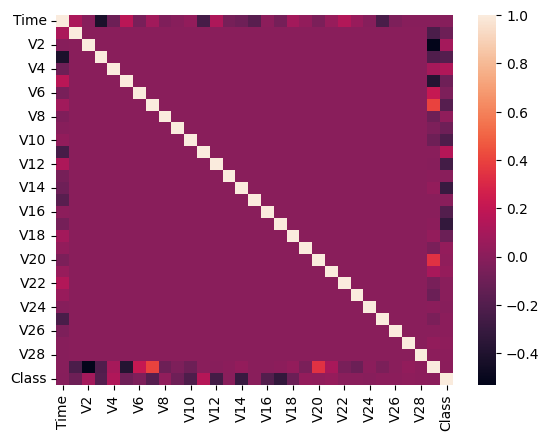

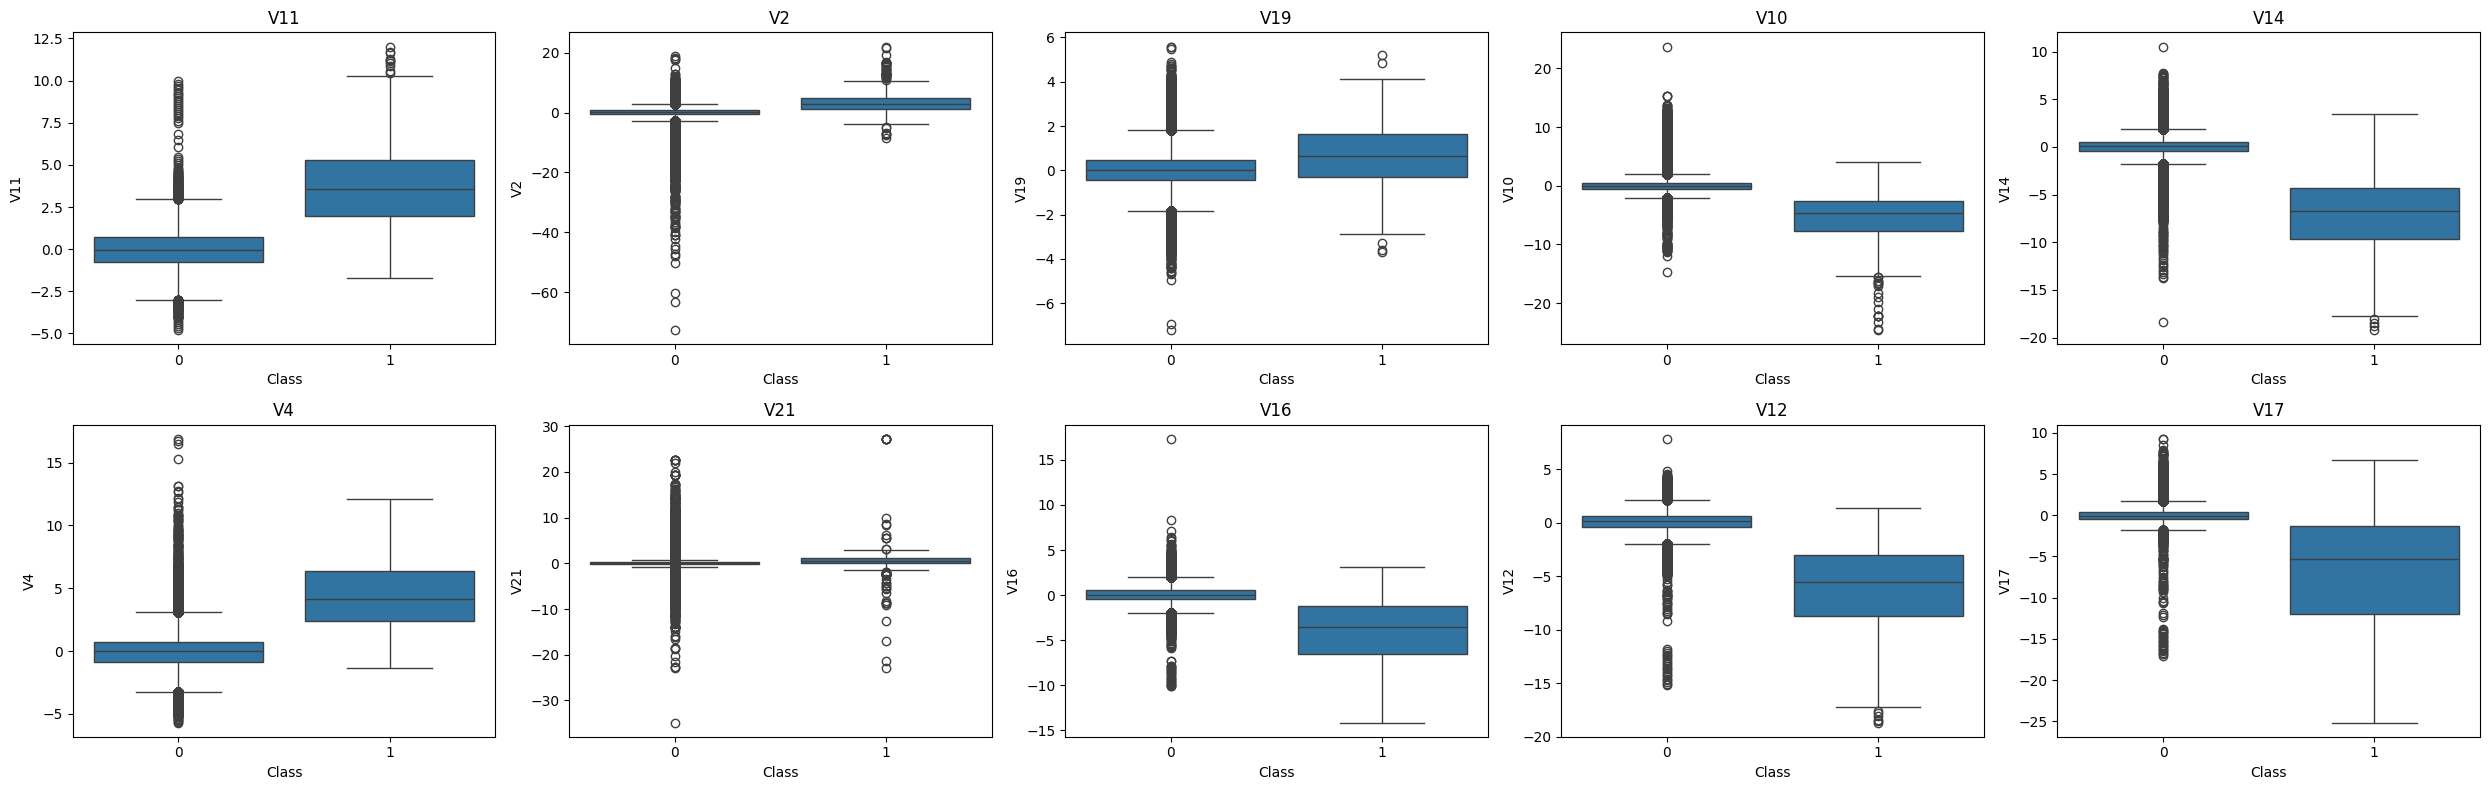

In [ ]:
visualize_most_correlated(data)

This is using the unbalanced data: now lets check the balanced data

          Class
Class  1.000000
V4     0.710284
V11    0.687722
V2     0.496125
V19    0.287148
V20    0.174228
        Class
V3  -0.569518
V16 -0.598116
V10 -0.627956
V12 -0.686219
V14 -0.746504


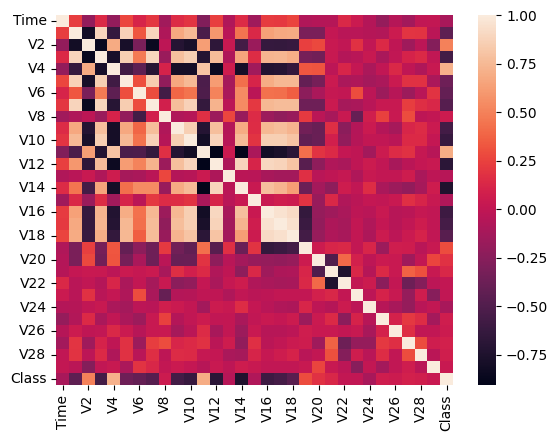

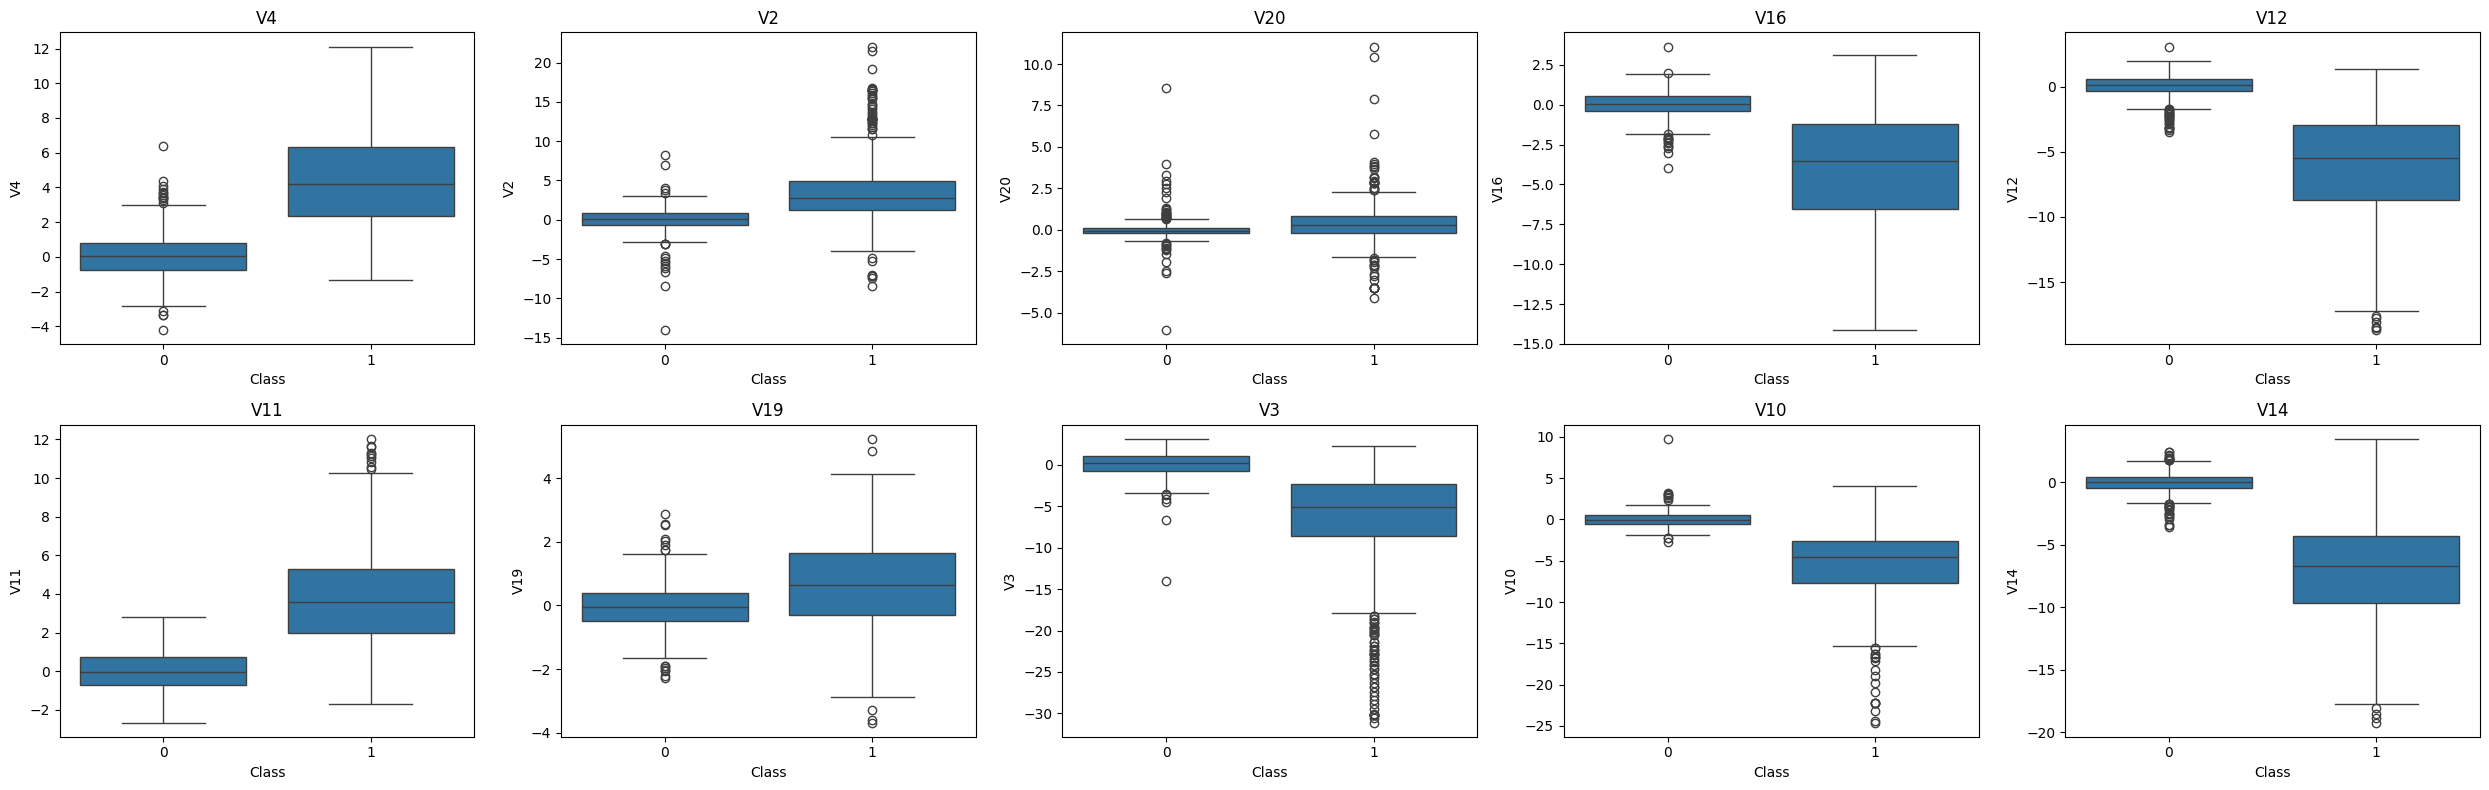

In [ ]:
visualize_most_correlated(balanced_data)

###**Plot and Clustering to Visualize Seperability**

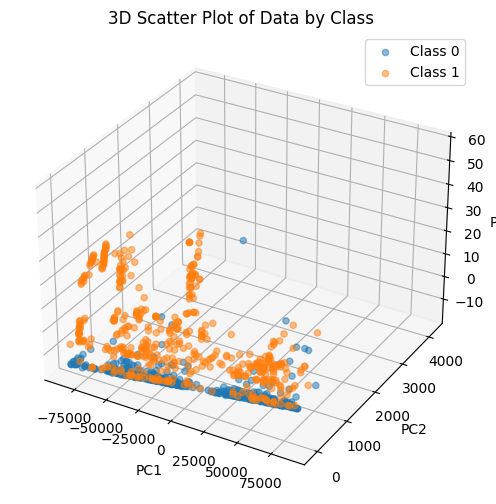

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Remove class label
balanced_X = balanced_data.drop('Class', axis=1)

# Perform PCA
pca = PCA(n_components=3)
pca.fit(balanced_X)
data_projected = pca.transform(balanced_X)

# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data points for each class
ax.scatter(data_projected[balanced_data['Class'] == 0, 0],
           data_projected[balanced_data['Class'] == 0, 1],
           data_projected[balanced_data['Class'] == 0, 2],
           label='Class 0', alpha=0.5)

ax.scatter(data_projected[balanced_data['Class'] == 1, 0],
           data_projected[balanced_data['Class'] == 1, 1],
           data_projected[balanced_data['Class'] == 1, 2],
           label='Class 1', alpha=0.5)

# Set labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of Data by Class')

# Add legend and show plot
ax.legend()
plt.show()


Doesn't look super useful. Lets try clustering vis in 2d

In [ ]:
from sklearn.preprocessing import StandardScaler
balanced_X = balanced_data.drop('Class', axis=1)
balanced_y = balanced_data.Class

scaler = StandardScaler()
balanced_X_scaled = scaler.fit_transform(balanced_X)

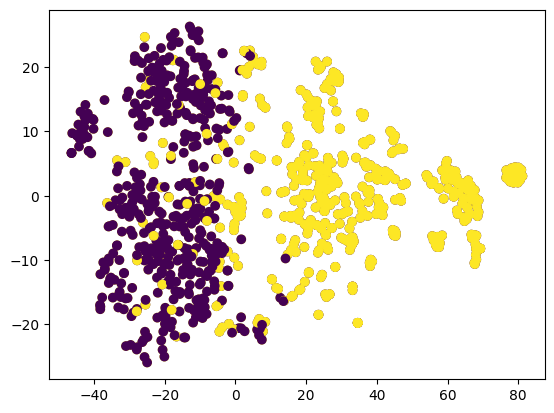

In [ ]:
# T-SNE
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(balanced_X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(balanced_y==0), label='Non-Fraud')
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(balanced_y==1), label='Fraud')

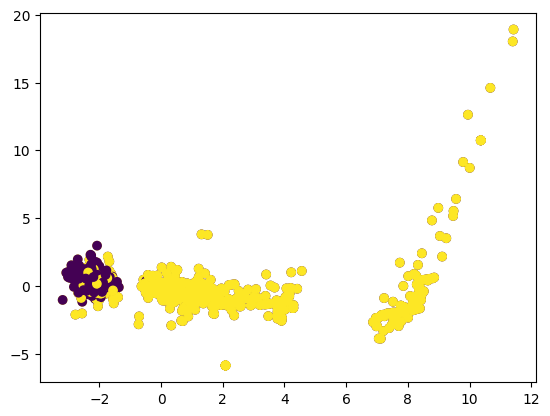

In [ ]:
# 2d PCA
X_pca = PCA(n_components=2).fit_transform(balanced_X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], c=(balanced_y==0), label='Non-Fraud')
plt.scatter(X_pca[:,0], X_pca[:,1], c=(balanced_y==1), label='Fraud')

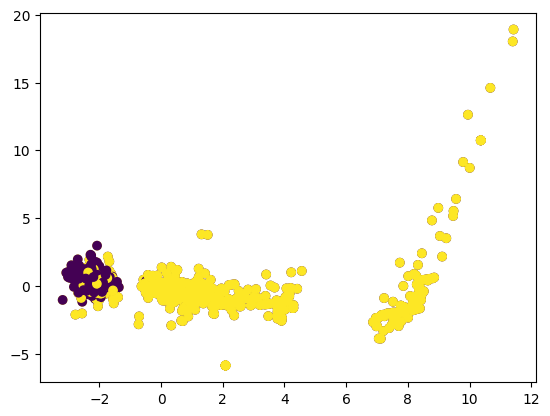

In [ ]:
# Truncated SVD
from sklearn.decomposition import TruncatedSVD

X_svd = PCA(n_components=2).fit_transform(balanced_X_scaled)

plt.scatter(X_svd[:,0], X_svd[:,1], c=(balanced_y==0), label='Non-Fraud')
plt.scatter(X_svd[:,0], X_svd[:,1], c=(balanced_y==1), label='Fraud')

Looks like the two classes are very seperatable

## Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# I call the train part just "X" and "y", because it is further broken down into train and validation

# Separate features and target
X = data.drop('Class', axis=1)
y = data['Class']

# Train test split, stratifing on label
X, X_test, y, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Standardize the features: do train and test seperate to prevent data leakage
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)

# Make everything numpy arrays
X = X.values
y = y.values

## Spot Checking ML Algorithms
**Metrics**

The main metric that I am taking into account is the f2-score. The f2-score, like the f1-score, combines precision and recall into a single score. The difference is that recall is given more weight that precision in an f2 score.

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import fbeta_score

from sklearn.model_selection import StratifiedKFold

def validate_model(model, X, y):
    print(f"Model: {model.__class__.__name__}")
    prec_list = []
    rec_list = []
    roc_auc_list = []
    f1_list = []
    f2_list = []

    # Stratified k-fold CV
    skf = StratifiedKFold(5)
    for i, (train_index, test_index) in enumerate(skf.split(X_scaled, y)):
        # Split into training and validation
        X_train, X_val = X_scaled[train_index], X_scaled[test_index]
        y_train, y_val = y[train_index], y[test_index]

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_prob = model.predict_proba(X_val)[:,1]

        # Score predictions and add to overall list for the model
        precision = precision_score(y_val, y_pred, average='binary', pos_label=1)
        recall = recall_score(y_val, y_pred, average='binary', pos_label=1)
        ar_auc = roc_auc_score(y_val, y_pred_prob)
        f1 = fbeta_score(y_val, y_pred, beta=1)
        f2 = fbeta_score(y_val, y_pred, beta=2)

        prec_list.append(precision)
        rec_list.append(recall)
        roc_auc_list.append(ar_auc)
        f1_list.append(f1)
        f2_list.append(f2)

    # Get avg metrics across all folds
    avg_prec = np.mean(prec_list)
    avg_rec = np.mean(rec_list)
    avg_roc_auc = np.mean(roc_auc_list)
    avg_f1 = np.mean(f1_list)
    avg_f2 = np.mean(f2_list)

    # print(prec_list)
    # print(rec_list)
    # print(roc_auc_list)
    # print(f1_list)
    # print(f2_list)

    # Print metrics
    print('AVG VALIDATION METRICS:')
    print(f"Precision: {avg_prec:.2f}")
    print(f"Recall: {avg_rec:.2f}")
    print(f"ROC AUC: {avg_roc_auc:.2f}")
    print(f"F1 score: {avg_f1:.2f}")
    print(f"F2 score: {avg_f2:.2f}")
    print()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

from sklearn.svm import SVC

In [ ]:
models = [SVC(probability=True), AdaBoostClassifier()]

for model in models:
    validate_model(model, X_scaled, y)

Model: SVC
AVG VALIDATION METRICS:
Precision: 0.95
Recall: 0.65
ROC AUC: 0.94
F1 score: 0.77
F2 score: 0.69

Model: AdaBoostClassifier
AVG VALIDATION METRICS:
Precision: 0.82
Recall: 0.70
ROC AUC: 0.97
F1 score: 0.75
F2 score: 0.72



Perhaps SVC did not perform as well because it is sensitive to imbalanced data. We will try to remedy this later in the 'cost sensitive' section.


Adaboost performed pretty well, likely because it assigns higher weights to misclassified samples in weak learners. This may help performance on imbalanced datasets

In [ ]:
# Define models
models = [
    LogisticRegression(solver='liblinear', class_weight='balanced'),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    DecisionTreeClassifier(),
    KNeighborsClassifier()
]

for model in models:
    validate_model(model, X_scaled, y)

Model: LogisticRegression
AVG VALIDATION METRICS:
Precision: 0.06
Recall: 0.91
ROC AUC: 0.97
F1 score: 0.12
F2 score: 0.24

Model: LinearDiscriminantAnalysis
AVG VALIDATION METRICS:
Precision: 0.87
Recall: 0.76
ROC AUC: 0.98
F1 score: 0.81
F2 score: 0.78

Model: GaussianNB
AVG VALIDATION METRICS:
Precision: 0.06
Recall: 0.82
ROC AUC: 0.96
F1 score: 0.11
F2 score: 0.24

Model: DecisionTreeClassifier
AVG VALIDATION METRICS:
Precision: 0.72
Recall: 0.73
ROC AUC: 0.86
F1 score: 0.72
F2 score: 0.73

Model: KNeighborsClassifier
AVG VALIDATION METRICS:
Precision: 0.91
Recall: 0.78
ROC AUC: 0.93
F1 score: 0.84
F2 score: 0.80



LogisticRegression and GaussianNB did not perform well. Both have high recall and very low precision. Likely because of a hard threshold, they overassign to the minority class. Changing threshold values is explored further below.

LDA and KNN performed well, suggesting that the classes are well seperated.

Decision tree performed well, possibly because they can handle complex nonliner relationships.

In [ ]:
m2 = [BaggingClassifier(), RandomForestClassifier()]

for model in m2:
    validate_model(model, X_scaled, y)

Model: BaggingClassifier
AVG VALIDATION METRICS:
Precision: 0.91
Recall: 0.77
ROC AUC: 0.92
F1 score: 0.83
F2 score: 0.79

Model: RandomForestClassifier
AVG VALIDATION METRICS:
Precision: 0.94
Recall: 0.78
ROC AUC: 0.95
F1 score: 0.85
F2 score: 0.81



Both Bagging and RandomForest perform well, likely due to their ability to model complex relationships, and their robustness to imbalanced data.

**Top Performers Based on F2 Score**:
1. Random Forest: 0.81
2. KNN: 0.80
3. Bagging: 0.79
4. LDA: 0.78
5. Decision Tree: 0.73







## Spot Check Imbalance Algorithms
Checking imbalance algorithms, choosing a single classifier to use for all of them. Lets choose the 2nd best performer, KNN, because its fast

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import fbeta_score

def test_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_prob = model.predict_proba(X_test_scaled)[:,1]

    # Score predictions
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    ar_auc = roc_auc_score(y_test, y_pred_prob)
    f1 = fbeta_score(y_test, y_pred, beta=1)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    # Print metrics
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"ROC AUC: {ar_auc:.2f}")
    print(f"F1 score: {f1:.2f}")
    print(f"F2 score: {f2:.2f}")
    print()

### Oversampling:
**Synthetic Minority Oversampling Technique (SMOTE)**
- Randomly pick a point from the minority class and compute the k-nearest neighbors
- Synthetic points are added between the
chosen point and its neighbors

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

print('Before SMOTE (baseline):')
print(Counter(y))
test_model(X_scaled, y, model)
print()

# Test different ratios
for ss in [0.05, 0.1, 0.25 ,0.5, 1]:
    sampler = SMOTE(sampling_strategy=ss)
    X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)
    print(f'After SMOTE {ss}')
    print(Counter(y_resampled))

    test_model(X_resampled, y_resampled, model)

Before SMOTE (baseline):
Counter({0: 227451, 1: 394})
Precision: 0.91
Recall: 0.84
ROC AUC: 0.94
F1 score: 0.87
F2 score: 0.85


After SMOTE 0.05
Counter({0: 227451, 1: 11372})
Precision: 0.57
Recall: 0.89
ROC AUC: 0.95
F1 score: 0.69
F2 score: 0.80

After SMOTE 0.1
Counter({0: 227451, 1: 22745})
Precision: 0.52
Recall: 0.91
ROC AUC: 0.95
F1 score: 0.66
F2 score: 0.79

After SMOTE 0.25
Counter({0: 227451, 1: 56862})
Precision: 0.49
Recall: 0.91
ROC AUC: 0.95
F1 score: 0.64
F2 score: 0.78

After SMOTE 0.5
Counter({0: 227451, 1: 113725})
Precision: 0.49
Recall: 0.91
ROC AUC: 0.95
F1 score: 0.63
F2 score: 0.77

After SMOTE 1
Counter({0: 227451, 1: 227451})
Precision: 0.48
Recall: 0.91
ROC AUC: 0.95
F1 score: 0.62
F2 score: 0.77



Leads to decrease in performance. Lets try smaller values

In [ ]:

model = KNeighborsClassifier()

for ss in [0.005, 0.01]:
    sampler = SMOTE(sampling_strategy=ss)
    X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)
    print(f'After SMOTE {ss}')
    print(Counter(y_resampled))

    test_model(X_resampled, y_resampled, model)

After SMOTE 0.005
Counter({0: 227451, 1: 1137})
Precision: 0.80
Recall: 0.88
ROC AUC: 0.94
F1 score: 0.83
F2 score: 0.86

After SMOTE 0.01
Counter({0: 227451, 1: 2274})
Precision: 0.69
Recall: 0.88
ROC AUC: 0.95
F1 score: 0.77
F2 score: 0.83



Seems like a very small ovresampling is the most beneficial.

**Random Oversampling**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

model = KNeighborsClassifier()

# Test different ratios
for ss in [0.005, 0.01, 0.05, 0.1, 0.25]:
    sampler = RandomOverSampler(sampling_strategy=ss)
    X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)
    print(f'After RandomOverSampler {ss}')
    print(Counter(y_resampled))

    test_model(X_resampled, y_resampled, model)

After RandomOverSampler 0.005
Counter({0: 227451, 1: 1137})
Precision: 0.72
Recall: 0.88
ROC AUC: 0.94
F1 score: 0.79
F2 score: 0.84

After RandomOverSampler 0.01
Counter({0: 227451, 1: 2274})
Precision: 0.66
Recall: 0.88
ROC AUC: 0.94
F1 score: 0.75
F2 score: 0.82

After RandomOverSampler 0.05
Counter({0: 227451, 1: 11372})
Precision: 0.66
Recall: 0.88
ROC AUC: 0.94
F1 score: 0.75
F2 score: 0.82

After RandomOverSampler 0.1
Counter({0: 227451, 1: 22745})
Precision: 0.66
Recall: 0.88
ROC AUC: 0.94
F1 score: 0.75
F2 score: 0.82

After RandomOverSampler 0.25
Counter({0: 227451, 1: 56862})
Precision: 0.66
Recall: 0.88
ROC AUC: 0.94
F1 score: 0.75
F2 score: 0.82



### Undersampling
random, tomek, and edited nearest neighbors


In [ ]:
# Random undersampling
from imblearn.under_sampling import RandomUnderSampler

model = KNeighborsClassifier()

# Test different ratios
for ss in [0.01, 0.1, 0.5, 1.0]:
    sampler = RandomUnderSampler(sampling_strategy=ss)
    X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)
    print(f'After RandomUnderSampler {ss}')
    print(Counter(y_resampled))

    test_model(X_resampled, y_resampled, model)

After RandomUnderSampler 0.01
Counter({0: 39400, 1: 394})
Precision: 0.80
Recall: 0.89
ROC AUC: 0.95
F1 score: 0.84
F2 score: 0.87

After RandomUnderSampler 0.1
Counter({0: 3940, 1: 394})
Precision: 0.48
Recall: 0.92
ROC AUC: 0.97
F1 score: 0.63
F2 score: 0.78

After RandomUnderSampler 0.5
Counter({0: 788, 1: 394})
Precision: 0.11
Recall: 0.93
ROC AUC: 0.97
F1 score: 0.20
F2 score: 0.37

After RandomUnderSampler 1.0
Counter({0: 394, 1: 394})
Precision: 0.05
Recall: 0.94
ROC AUC: 0.98
F1 score: 0.10
F2 score: 0.21



**Tomek Links**
- a tomek link is a pair of very close instances of oppositve classes
- removeing the majority class in each pair increases the spacae between the two classes


In [ ]:
# Tomek links
from imblearn.under_sampling import TomekLinks
from collections import Counter

model = KNeighborsClassifier()

sampler = TomekLinks()
X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)
print('After TomekLinks')
print(Counter(y_resampled))

test_model(X_resampled, y_resampled, model)

After TomekLinks
Counter({0: 227428, 1: 394})
Precision: 0.89
Recall: 0.84
ROC AUC: 0.94
F1 score: 0.86
F2 score: 0.85



In [ ]:
# Edited Nearest Neighbors
# Similar to tomek, but removes majority class observations when any or most of its NNs are minorty

from imblearn.under_sampling import EditedNearestNeighbours

model = KNeighborsClassifier()

sampler = EditedNearestNeighbours()
X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)
print(f'After EditedNearestNeighbours')
print(Counter(y_resampled))

test_model(X_resampled, y_resampled, model)

After EditedNearestNeighbours
Counter({0: 227302, 1: 394})
Precision: 0.87
Recall: 0.84
ROC AUC: 0.94
F1 score: 0.85
F2 score: 0.84



### Combining Oversampling and Undersampling

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import TomekLinks

# Baseline
model = KNeighborsClassifier()
print('baseline:')
print(Counter(y))
test_model(X_scaled, y, model)
print()

baseline:
Counter({0: 227451, 1: 394})
Precision: 0.91
Recall: 0.84
ROC AUC: 0.94
F1 score: 0.87
F2 score: 0.85




In [ ]:
# A small amount of smote helped performance
smote = SMOTE(sampling_strategy=0.005)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

print('After SMOTE oversampling:')
print(Counter(y_smote))
test_model(X_smote, y_smote, model)
print()

After SMOTE oversampling:
Counter({0: 227451, 1: 1137})
Precision: 0.83
Recall: 0.88
ROC AUC: 0.95
F1 score: 0.85
F2 score: 0.87




In [ ]:
# A small amount of Random undersampling
from imblearn.under_sampling import RandomUnderSampler

random_us = RandomUnderSampler(sampling_strategy=0.0075)
X_2, y_2 = random_us.fit_resample(X_smote, y_smote)

print('After SMOTE + random undersampling:')
print(Counter(y_2))
test_model(X_2, y_2, model)
print()

After SMOTE + random undersampling:
Counter({0: 151600, 1: 1137})
Precision: 0.77
Recall: 0.88
ROC AUC: 0.96
F1 score: 0.82
F2 score: 0.85




Hmmmm, seems like just SMOTE is the best

## Cost Sensitive Algorithms
modified ML algorithms designed to take the differing costs of missclassification into account when fitting

**Penalized-SVM**:
Class weight balanced penalizes mistakes on the minority class proportional to how underrepresented it is


In [ ]:
# Penalized-SVM
from sklearn.svm import SVC

print('Normal:')
psvm = SVC(probability=True)
validate_model(psvm, X_scaled, y)

print('Balanced:')
psvm = SVC(class_weight='balanced', probability=True)
validate_model(psvm, X_scaled, y)

Normal:
Model: SVC
AVG VALIDATION METRICS:
Precision: 0.95
Recall: 0.64
ROC AUC: 0.95
F1 score: 0.77
F2 score: 0.68

Balanced:
Model: SVC


In [ ]:
from sklearn.tree import DecisionTreeClassifier

print('Normal')
wdt = DecisionTreeClassifier()
validate_model(wdt, X_scaled, y)

print('Balanced')
wdt = DecisionTreeClassifier(class_weight='balanced')
validate_model(wdt, X_scaled, y)

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier

print('Normal')
wlr = LogisticRegression(class_weight='balanced')
validate_model(wlr, X_scaled, y)

print('Balanced')
wlr = LogisticRegression(class_weight='balanced')
validate_model(wlr, X_scaled, y)

## One-Class Algorithms
algorithms used for outlier detection and anomaly detection. They are called one-class classification algos when used for classification

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from collections import Counter
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import fbeta_score


# Seperate majority class in train data
X_scaled_0 = X_scaled[y==0]

def test_oneclass_model(model):
    # Train on just the majority class. We are treating the minority class as the anomaly
    model.fit(X_scaled_0)
    y_pred = model.predict(X_test_scaled)

    # Convert y_pred to same format as test labels
    y_pred[y_pred==1] = 0
    y_pred[y_pred==-1] = 1

    # Score predictions
    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    f1 = fbeta_score(y_test, y_pred, beta=1)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    # Print metrics
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    print(f"F2 score: {f2:.2f}")
    print()

In [ ]:
oc_svm = OneClassSVM()
iso_f = IsolationForest()

test_oneclass_model(oc_svm)
test_oneclass_model(iso_f)

Precision: 0.00
Recall: 0.98
F1 score: 0.01
F2 score: 0.02

Precision: 0.03
Recall: 0.85
F1 score: 0.06
F2 score: 0.14



In [ ]:
from sklearn.covariance import MinCovDet
from sklearn.neighbors import LocalOutlierFactor

# mcd = MinCovDet()
lof = LocalOutlierFactor(novelty=True)

# test_oneclass_model(mcd)
test_oneclass_model(lof)

Precision: 0.01
Recall: 0.21
F1 score: 0.01
F2 score: 0.03



OneClassSVM and Isolation forests did not perform well, with both having low precision and high recall. It seems like it overly predicted anomalies. It may be because many of the majority class samples are distributed very far.

LocalOutlierFactor performed extremely poorly. This may be because a density-based method does not work on this data. Perhaps many of the data points of the minority class are in a similar space and thus density as the majority points. Perhaps further featuer engineering is needed here

## Probabality Tuning Algorithms

In [ ]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.pyplot as plt
def get_cal_curve(model):
    model.fit(X_scaled, y)
    y_pred_prob = model.predict_proba(X_test_scaled)[:,1]
    fop, mpv = calibration_curve(y_test, y_pred_prob, n_bins=10)
    disp = CalibrationDisplay(fop, mpv, y_pred_prob)
    disp.title = f"Model: {model.__class__.__name__}"
    disp.plot()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

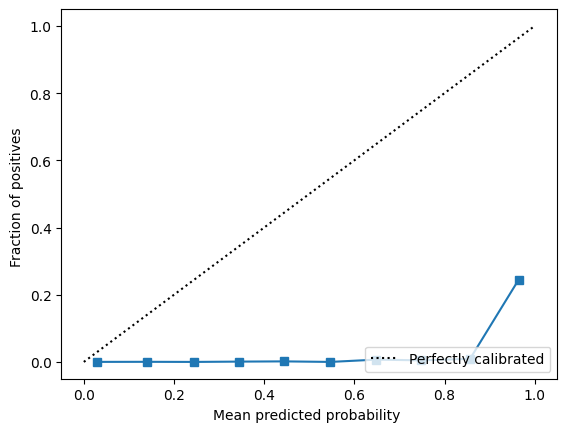

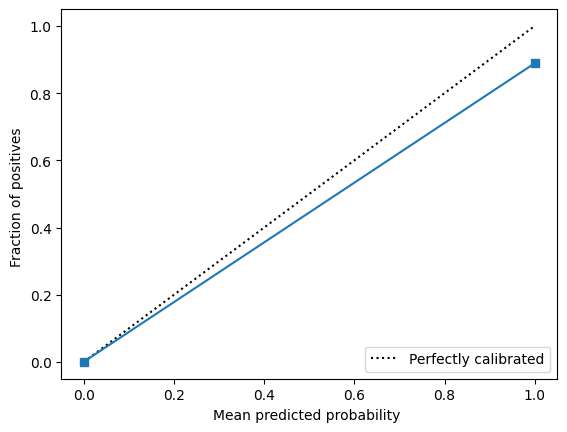

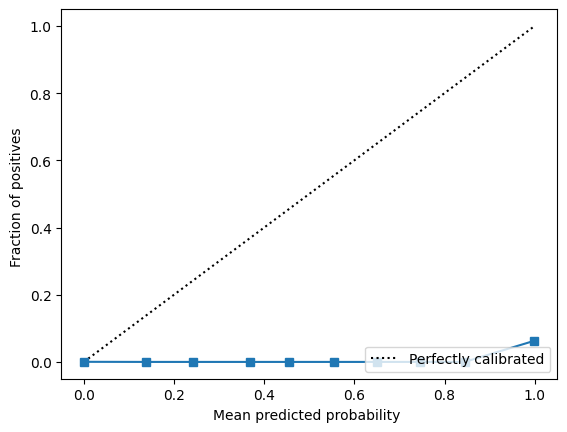

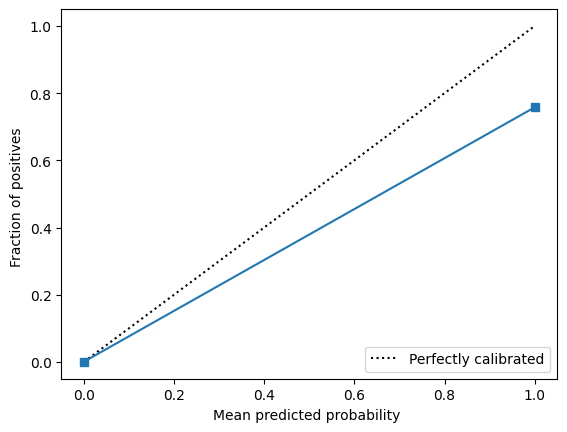

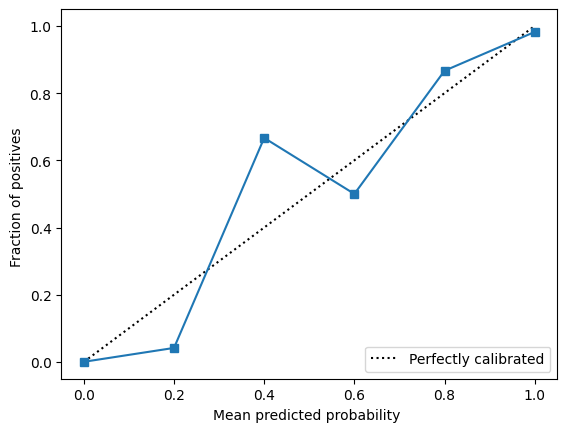

In [ ]:
models = [
    LogisticRegression(solver='liblinear', class_weight='balanced'),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    DecisionTreeClassifier(),
    KNeighborsClassifier()
]

m2 = [BaggingClassifier(), RandomForestClassifier()]

for model in models:
    get_cal_curve(model)

Just as expected, Logreg and GaussianNB are poorly caliabrated

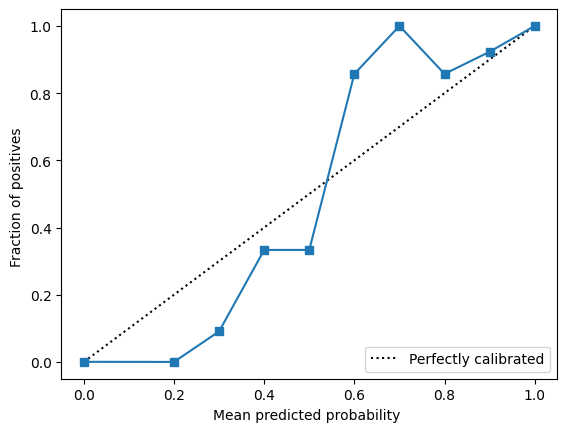

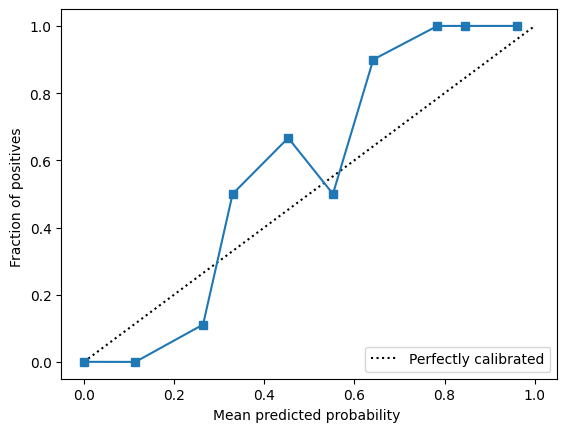

In [ ]:
for model in m2:
    get_cal_curve(model)

It looks like all but KNN, bagging, and randomforest are poorly calibrated. **Lets try recalibrating some**

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
def calibrate_and_evaluate(base_model):
    print(f"Model: {model.__class__.__name__}")

    # Get uncalibrated results first
    print('Uncalibrated:')
    base_model.fit(X_scaled, y)
    y_pred = base_model.predict(X_test_scaled)

    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print()

    # Then get calibrated model results
    print('Calibrated:')
    calibrated_model = CalibratedClassifierCV(base_model)
    calibrated_model.fit(X_scaled, y)

    y_pred = calibrated_model.predict(X_test_scaled)

    precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
    recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F2: {f2:.2f}')
    print()
    print()

In [ ]:
models1 = [LogisticRegression(solver='liblinear', class_weight='balanced'),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    DecisionTreeClassifier()]

models2 = [KNeighborsClassifier(), BaggingClassifier(), RandomForestClassifier()]

In [ ]:
for model in models1:
    calibrate_and_evaluate(model)


Improved everything except for GaussianNB. However, out of all of these, only DecisionTreeClassifier is viable.

GaussianNB performance actuall became 0. The reason may be because the model may be extremely sensitive to threshold changes because of the very imbalanced data.

In [ ]:
for model in models2:
    calibrate_and_evaluate(model)

## Hyperparameter Tuning

**TOP 5 ALGORITHMS**:

LDA, Decision Tree (calibrated), KNN, Bagging, Random Forest

small SMOTE oversampling, EditedNearestNeighbors

### Data preprocessing

In [ ]:
from collections import Counter

print('Before oversampling:')
print(Counter(y))

# MINOR smote oversampling
from imblearn.over_sampling import SMOTE

sampler = SMOTE(sampling_strategy=0.01)
X_train_final, y_train_final = sampler.fit_resample(X_scaled, y)

print('After oversampling:')
print(Counter(y_resampled))


# # EditedNearestNeighbors
# from imblearn.under_sampling import EditedNearestNeighbours

# sampler = EditedNearestNeighbours()
# X_train_final, y_train_final = sampler.fit_resample(X_resampled, y_resampled)

# print('After oversampling and Edited nearest neighbors:')
# print(Counter(y_train_final))

Before oversampling:
Counter({0: 227451, 1: 394})
After oversampling:
Counter({0: 227451, 1: 2274})
After oversampling and Edited nearest neighbors:
Counter({0: 227196, 1: 2274})


### Hyperparameter Tuning Each Algorithm

In [ ]:
# Set scoring methods first
from sklearn.metrics import make_scorer, recall_score, precision_score, fbeta_score
from sklearn.model_selection import GridSearchCV


scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f2':make_scorer(fbeta_score, beta=2)
}

results = {}

In [ ]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Set up the model, parameters, and gridsearch
lda = LinearDiscriminantAnalysis()
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']
}

gs = GridSearchCV(estimator=lda,
                  param_grid=param_grid,
                  scoring=scoring,
                  refit='f2',
                  cv=5)

# Fit and predict
gs.fit(X_train_final, y_train_final)

best_params = gs.best_params_
print(best_params)
y_pred = gs.predict(X_test_scaled)

# Score and print results
precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2)
results['lda'] = [precision, recall, f2]

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F2-Score: {f2}')

{'solver': 'svd'}
Precision: 0.8409090909090909
Recall: 0.7551020408163265
F2-Score: 0.7708333333333333


In [ ]:
# Calibrated balanced decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV

# Set up the model, parameters, and gridsearch
dtc = DecisionTreeClassifier()
c_dt = CalibratedClassifierCV(dtc)

label_weights_values = len(y_train_final) / (2 * np.bincount(y_train_final))
label_weights = {0: label_weights_values[0], 1: label_weights_values[1]}

param_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__splitter': ['best', 'random'],
    'estimator__random_state': [42],
    'estimator__class_weight': [label_weights],
    'method': ['sigmoid', 'isotonic']
}

gs = GridSearchCV(estimator=c_dt,
                  param_grid=param_grid,
                  scoring=scoring,
                  refit='f2',
                  cv=5)

# Fit and predict
gs.fit(X_train_final, y_train_final)

best_params = gs.best_params_
print(best_params)
y_pred = gs.predict(X_test_scaled)

# Score and print results
precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2)
results['dt'] = [precision, recall, f2]


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F2-Score: {f2}')

{'estimator__class_weight': {0: 0.5050044895156605, 1: 50.45514511873351}, 'estimator__criterion': 'entropy', 'estimator__random_state': 42, 'estimator__splitter': 'random', 'method': 'sigmoid'}
Precision: 0.8315789473684211
Recall: 0.8061224489795918
F2-Score: 0.811088295687885


In [ ]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

# Set up the model, parameters, and gridsearch
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 10, 20, 50],
    'weights': ['uniform', 'distance'],
}

gs = GridSearchCV(estimator=knn,
                  param_grid=param_grid,
                  scoring=scoring,
                  refit='f2',
                  cv=5)

# Fit and predict
gs.fit(X_train_final, y_train_final)

best_params = gs.best_params_
print(best_params)
y_pred = gs.predict(X_test_scaled)

# Score and print results
precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2)
results['knn'] = [precision, recall, f2]


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F2-Score: {f2}')

{'n_neighbors': 3, 'weights': 'distance'}
Precision: 0.680327868852459
Recall: 0.8469387755102041
F2-Score: 0.8073929961089494


In [ ]:
# Bagging
from sklearn.ensemble import BaggingClassifier

# Set up the model, parameters, and gridsearch
bc = BaggingClassifier()

param_grid = {
    'n_estimators': [5, 10, 20],
    'max_samples': [0.25, 0.5, 1.0],
    'max_features': [0.25, 0.5, 1.0]
    }

gs = GridSearchCV(estimator=bc,
                  param_grid=param_grid,
                  scoring=scoring,
                  refit='f2',
                  cv=5)

# Fit and predict
gs.fit(X_train_final, y_train_final)

best_params = gs.best_params_
print(best_params)
y_pred = gs.predict(X_test_scaled)

# Score and print results
precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2)
results['bagging'] = [precision, recall, f2]


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F2-Score: {f2}')

{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 5}
Precision: 0.7788461538461539
Recall: 0.826530612244898
F2-Score: 0.8165322580645161


In [ ]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier

# Set up the model, parameters, and gridsearch
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample']
    }

gs = GridSearchCV(estimator=rf,
                  param_grid=param_grid,
                  scoring=scoring,
                  refit='f2',
                  cv=5)

# Fit and predict
gs.fit(X_train_final, y_train_final)

best_params = gs.best_params_
print(best_params)
y_pred = gs.predict(X_test_scaled)

# Score and print results
precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2)
results['randomforest'] = [precision, recall, f2]


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F2-Score: {f2}')

{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'n_estimators': 200}
Precision: 0.8279569892473119
Recall: 0.7857142857142857
F2-Score: 0.7938144329896906


In [ ]:
results

{'lda': [0.8409090909090909, 0.7551020408163265, 0.7708333333333333],
 'dt': [0.8315789473684211, 0.8061224489795918, 0.811088295687885],
 'knn': [0.680327868852459, 0.8469387755102041, 0.8073929961089494],
 'bagging': [0.7788461538461539, 0.826530612244898, 0.8165322580645161],
 'randomforest': [0.8279569892473119, 0.7857142857142857, 0.7938144329896906]}

**Looks like Bagging decision trees has the best performance on the testing set!**

# Using Auto-encoder in Keras Functional API
https://www.kaggle.com/code/shivamb/semi-supervised-classification-using-autoencoders

Use autoencoder to get an easily seperable representation of the data


In [5]:
# Mount drive
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# Load data
data = pd.read_csv('/content/drive/MyDrive/Projects/credit_card_fraud/creditcard.csv')

Mounted at /content/drive


## Visual representation of raw data

In [6]:
# Use a sample of majority class for visualization
bau = data[data['Class']==0].sample(1000)
fraud = data[data['Class']==1]

sampled_data = pd.concat([bau, fraud]).sample(frac=1).reset_index(drop=True)

# Drop time too
sampled_X = sampled_data.drop(['Time', 'Class'], axis=1).values
sampled_y = sampled_data['Class'].values

In [7]:
from sklearn.manifold import TSNE

def plot_tsne(X, y):
    tsne = TSNE(n_components=2, random_state=42)
    X_t = tsne.fit_transform(X)

    plt.scatter(X_t[y==0, 0], X_t[y==0, 1], marker='o', color='b',
                alpha=0.8, label='Not Fraud')
    plt.scatter(X_t[y==1, 0], X_t[y==1, 1], marker='o', color='r',
                alpha=0.8, label='Fraud')
    plt.legend()

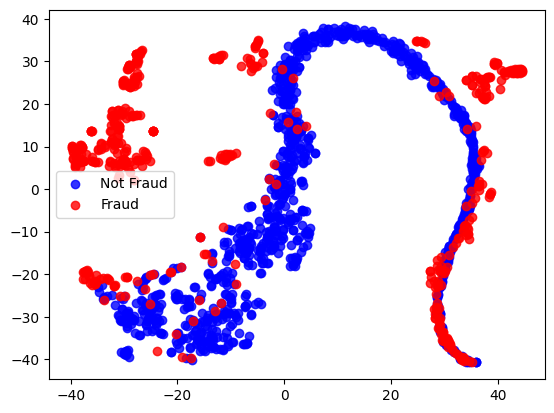

In [ ]:
plot_tsne(sampled_X, sampled_y)

## Autoencoder to encode data

In [8]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

The bottlenech is size 50, which is larger than the input dimension. However, this may allow the model to capture some complex patterns.

The first layer of the encoder is tanh activation, to help capture positive and negative values.

The first layer is also regularized, to encourage a sparse representation of the input data. A sparse representation ensures that only the relevant features are passed through the rest of the autoencoder, and reduces overfitting.

In [9]:
# Scale the data
X = data.drop(['Class', 'Time'], axis=1)
y = data['Class'].values

X_scaled = preprocessing.MinMaxScaler().fit_transform(X.values)
X_bau, X_fraud = X_scaled[y==0], X_scaled[y==1]

In [10]:
# Define autoencoder

# Input layer
input_layer = Input(shape=(X_scaled.shape[1],))

# Encoder
encoder = Dense(100, activation='tanh',
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(50, activation='relu')(encoder)

# Decoder
decoder = Dense(50, activation='tanh')(encoder)
decoder = Dense(100, activation='tanh')(decoder)

# Output layer
output_layer = Dense(X_scaled.shape[1], activation='relu')(decoder)

In [11]:
# Compile the autoencoder
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

In [12]:
X_bau.shape

(284315, 29)

In [13]:
# Early stopping
es = EarlyStopping(monitor='val_loss', patience=3)

# Use a subset of the bau cases to train the autoencoder
autoencoder.fit(X_bau[0:20000], X_bau[0:20000], batch_size=32, epochs=10,
                shuffle=True, validation_split=0.20, callbacks=es)

Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 0.1029 - val_loss: 0.1016
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0998 - val_loss: 0.1013
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0997 - val_loss: 0.1012
Epoch 4/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0869 - val_loss: 0.0838
Epoch 5/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0848 - val_loss: 0.0838
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0848 - val_loss: 0.0838
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0847 - val_loss: 0.0837
Epoch 8/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0847 - val_loss: 0.0837
Epoch 9/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0847 - val_loss: 0.0837
Epoch 10/10
500/500 [==============================] - 1s 3ms/step - loss: 0.0847 - val_loss: 0.0837

In [14]:
# Obtain the latent representations of the input
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [15]:
# Generate the hidden representations of the two classes
X_encoded = hidden_representation.predict(X_scaled)

8901/8901 [==============================] - 14s 2ms/step


In [16]:
X_encoded

array([[0.06558465, 0.05189397, 0.13708678, ..., 0.        , 0.        ,
        0.06839093],
       [0.09367684, 0.10462976, 0.11062551, ..., 0.        , 0.        ,
        0.07692897],
       [0.1078125 , 0.2023502 , 0.11307412, ..., 0.        , 0.        ,
        0.11523657],
       ...,
       [0.05098276, 0.06324307, 0.08167341, ..., 0.        , 0.        ,
        0.08256468],
       [0.01207966, 0.04333562, 0.10586518, ..., 0.        , 0.        ,
        0.08622062],
       [0.06847915, 0.04717619, 0.07041822, ..., 0.        , 0.        ,
        0.0757976 ]], dtype=float32)

In [17]:
X_encoded.shape

(284807, 50)

## Visualize encoded data

In [ ]:
# Sample the data again to get fewer of the bau instances
indices_0 = np.where(y==0)[0]
indices_1 = np.where(y==1)[0]

sampled_indices_0 = np.random.choice(indices_0, size=2000, replace=False)
all_indices = np.concatenate((indices_1, sampled_indices_0))

X_encoded_sampled = X_encoded[all_indices]
y_sampled = y[all_indices]

In [ ]:
X_encoded_sampled.shape

(2492, 50)

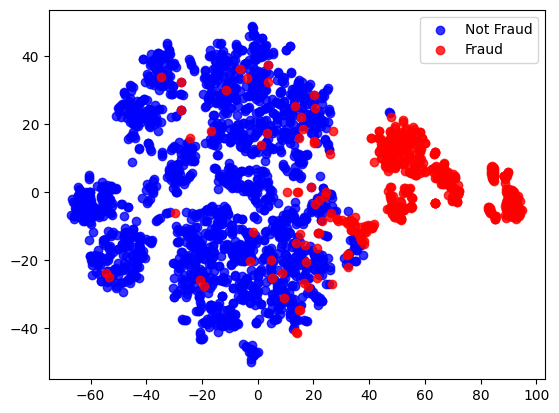

In [ ]:
# Visualize
plot_tsne(X_encoded_sampled, y_sampled)

In [21]:
# Now lets run a model on this data
# Bagging was the best performer in the first section
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import make_scorer, recall_score, precision_score, fbeta_score

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2,
                                                   stratify=y)

scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f2':make_scorer(fbeta_score, beta=2)
}

# Set up the model, parameters, and gridsearch
bc = BaggingClassifier()

param_grid = {
    'n_estimators': [5, 10, 20],
    'max_samples': [0.25, 0.5, 1.0],
    'max_features': [0.25, 0.5, 1.0]
    }

gs = GridSearchCV(estimator=bc,
                  param_grid=param_grid,
                  scoring=scoring,
                  refit='f2',
                  cv=5)

# Fit and predict
gs.fit(X_train, y_train)

best_params = gs.best_params_
print(best_params)
y_pred = gs.predict(X_test)

# Score and print results
precision = precision_score(y_test, y_pred, average='binary', pos_label=1)
recall = recall_score(y_test, y_pred, average='binary', pos_label=1)
f2 = fbeta_score(y_test, y_pred, beta=2)
# results['encoded_bagging'] = [precision, recall, f2]


print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F2-Score: {f2}')

{'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 20}
Precision: 0.9767441860465116
Recall: 0.8571428571428571
F2-Score: 0.8786610878661087


It did improve performance! This is now our best model!

**Encoding using autoencoder, then BaggingClassifier with {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 20}**
